<a href="https://colab.research.google.com/github/Bhanuprasadh/FMML-Assignment-Labs/blob/main/Copy_of_FMML_Module_9_Project(b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Module 9: Convolutional Neural Networks Project(b)

## Module coordinator: Kushagra Agarwal



<img src="https://hub.packtpub.com/wp-content/uploads/2018/04/iStock-851960058-696x464.jpg" width=850px/>

In this project, you will understand how you can perform emotion recognition using CNNs in a step-by-step manner. To make your task easier, we provide you the starter code for the project. It is expected that you should try to understand the project statement properly and perform the tasks in sequence. We will be using Pytorch framework for the implementation. You need to fill in the missing code parts to achieve a particular task. At the end, you will have a basic implementation ready for an emotion detection application.

Basic steps involved in Emotion Recognition:
- Face detection
- Building classifier
- Classifying emotions

We will use a popular FER2013 dataset for this project.

## Task 1: Explore the dataset
The dataset contains 48 x 48 grayscale facial images of faces.The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

<img src="https://www.researchgate.net/profile/Chaudhary-Aqdus/publication/349055345/figure/fig3/AS:987834383085568@1612529478973/FER-2013-sample-images-for-facial-emotion-recognition.jpg" width=650px/>

Import libraries

In [ ]:
# We have imported the necessary packages here. Feel free to import anything more you need!
import torch
import torchvision
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dlib
import cv2
from PIL import Image

### Download and load dataset

In [ ]:
!gdown https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
!unzip fer2013.csv.zip

Downloading...
From: https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
To: /content/fer2013.csv.zip
100% 101M/101M [00:01<00:00, 57.9MB/s] 
Archive:  fer2013.csv.zip
  inflating: fer2013.csv             


In [ ]:
# Load the dataset csv using pandas package. It displays the data in tabular form
emotion_data = pd.read_csv('./fer2013.csv')
print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [ ]:
# Class dictionary for dataset
classes = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

### Visualize a few images from dataset

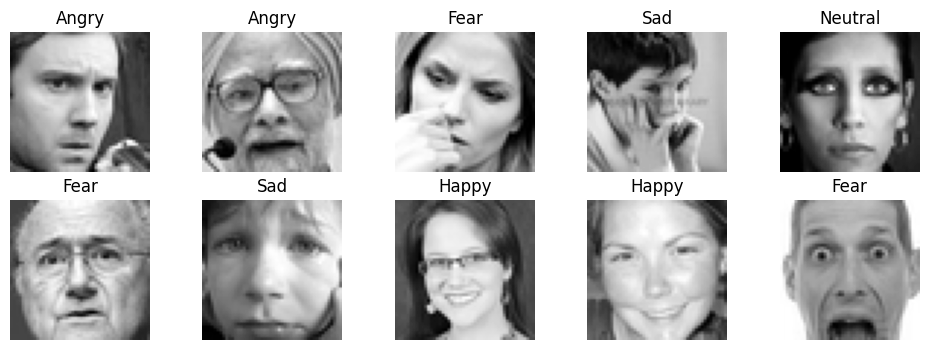

In [ ]:
fig = plt.figure(figsize=(12,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  # This is how we access ith row in 'pixels' column in the dataset table
  img = emotion_data.iloc[i]['pixels'].split(' ') # Converting into array of ints
  img = np.array(img).astype(int)

  # Labels for our dataset
  label = int(emotion_data.iloc[i]['emotion'])
  ax.imshow(img.reshape((48,48)), cmap='gray')
  ax.set_title(classes[label])
  ax.set_axis_off()
plt.show()

In [ ]:
names, counts = np.unique(emotion_data['Usage'].to_numpy(), return_counts=True)
print('Number of samples in {} = {}'.format(names[0], counts[0])) #testset
print('Number of samples in {} = {}'.format(names[1], counts[1])) #valset
print('Number of samples in {} = {}'.format(names[2], counts[2])) #trainset

Number of samples in PrivateTest = 3589
Number of samples in PublicTest = 3589
Number of samples in Training = 28709


### Distribution of class labels

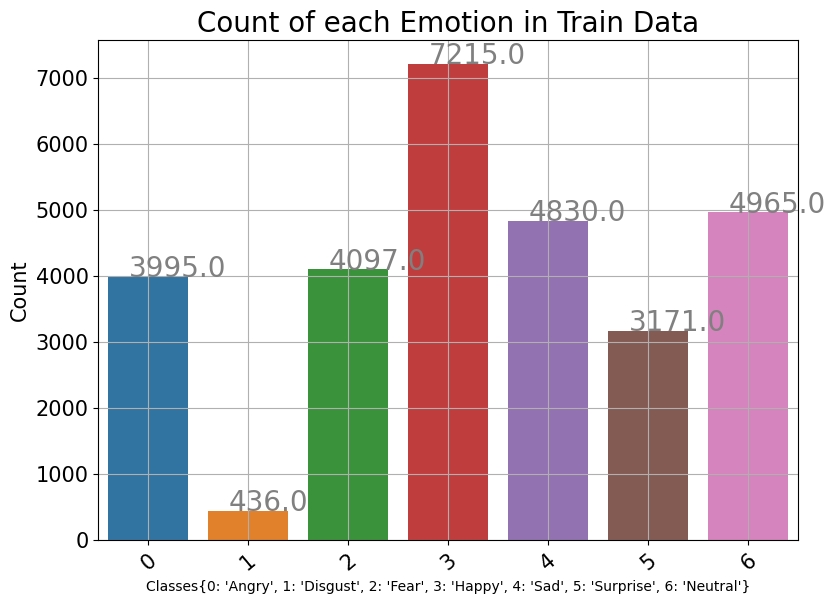

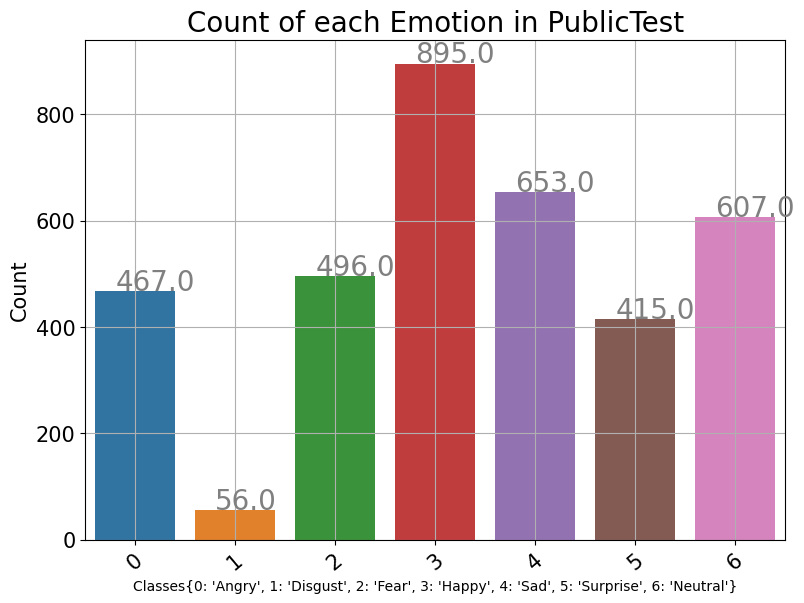

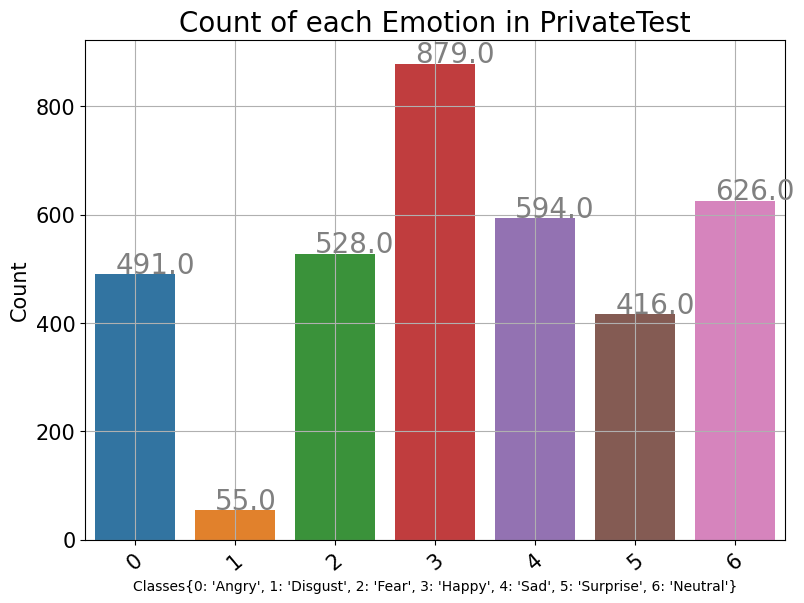

In [ ]:
# Plot bar chart showing number of samples per class in the train set
temp_train = emotion_data.loc[emotion_data['Usage'] == 'Training']
df_temp_train = temp_train.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in Train Data", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_train)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

### Task: Similarly, write the code below to plot the charts for remaining two sets also.
temp_train = emotion_data.loc[emotion_data['Usage'] == 'PublicTest']
df_temp_train = temp_train.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in PublicTest", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_train)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

# Plot bar chart showing number of samples per class in the PrivateTest
temp_train = emotion_data.loc[emotion_data['Usage'] == 'PrivateTest']
df_temp_train = temp_train.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in PrivateTest", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_train)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()



Note the imbalance in the data through above graphs.

Face detection: Many applications involving facial images as input data require face detection in the pipeline at this step. Here, we localise the face in the given image removing the irrelevant parts, making the face centered and occupying most of the part in the image. As mentioned earlier, our dataset already has more or less centered faces, so we will skip this step for now but when using some other dataset or using your own images (eg. from webcam) as you will do later, you can do this step to get a proper cropped face from the image.

## Task 2: Data preprocessing

### Creating train, validation and test sets

In [ ]:
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

for index, row in emotion_data.iterrows():
  k = row['pixels'].split(" ")

  if row['Usage'] == 'Training':
    X_train.append(np.array(k))
    y_train.append(row['emotion'])

  # Similarly write the conditions for test and val splits here
  ###### YOUR CODE HERE  ######
  if row['Usage'] == 'PublicTest':
    X_val.append(np.array(k))
    y_val.append(row['emotion'])

  if row['Usage'] == 'PrivateTest':
    X_test.append(np.array(k))
    y_test.append(row['emotion'])



X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape: ', X_train.shape, y_train.shape)
print('Validation set shape: ', X_val.shape, y_val.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (28709, 2304) (28709,)
Validation set shape:  (3589, 2304) (3589,)
Testing set shape:  (3589, 2304) (3589,)


In [ ]:
# To get data between 0 and 1
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
X_val = X_val.astype(float) / 255.

We will define a dataset wrapper over Pytorch Dataset class which takes in the numpy arrays we created and returns a sample with required preprocessing.

In [ ]:
class Fer2013Dataset(Dataset):
  def __init__(self, x, y, transforms=None):
    self.x = x.reshape((-1, 48, 48))
    self.y = y
    self.transforms= transforms

  def __getitem__(self, index):
    img, y = self.x[index], self.y[index]

    if self.transforms is not None:
        img = self.transforms(img)
    return img, y

  def __len__(self):
    return len(self.y)

In [ ]:
batch_size=32

transform = transforms.ToTensor()

# Create tensor dataset from above tensors
train_dataset = Fer2013Dataset(X_train, y_train, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)

val_dataset = Fer2013Dataset(X_val, y_val, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

test_dataset = Fer2013Dataset(X_test, y_test, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

## Task 3: Building a CNN model

In [ ]:
# Define your CNN architecture here
# To start with, let's say you can create a model with 4 relu-activated convs,
# each followed by a pooling layer. Then, you can add 2-3 fully connected layers

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #### YOUR CODE HERE  ####
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(2592, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 7 classes
        self.fc3 = nn.Linear(128, 7)

    def forward(self,x):
        #### YOUR CODE HERE  ####
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Device (CPU/GPU)
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the CNN
model = Net().to(device)
model.double()
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2592, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
)


In [ ]:

device

'cpu'

### Training/Testing functions

In [ ]:
def train(model, train_loader, loss_func, optimizer, num_epochs):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [ ]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

## Task 4: Training & Evaluation

### Train the model

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer with learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)   # Pick an optimizer you think is suitable

history = train(model, train_loader, criterion, optimizer, num_epochs=1)

Epoch 1/1, Loss: 0.0539, Accuracy: 30.3215


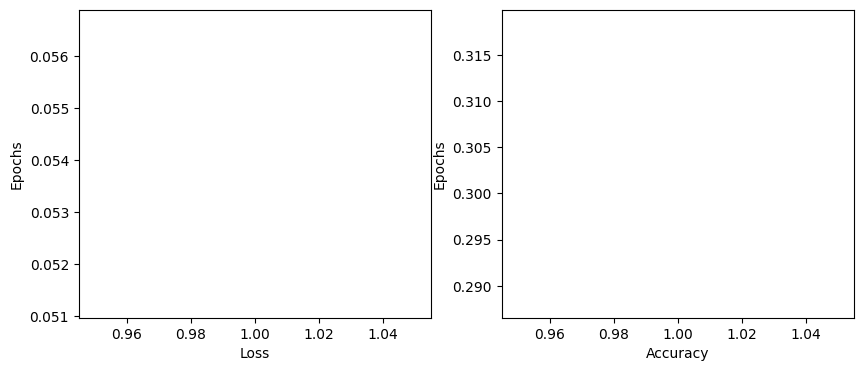

In [ ]:
# You can fine-tune your model looking at below plots
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(history[0])+1),history[0])
plt.xlabel('Loss')
plt.ylabel('Epochs')

ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(history[1])+1),history[1])
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

### Evaluate your model

In [ ]:
# Visualize top K predictions
def visualize_prediction(image, model, k=3):
  model.eval()

  preds = model(image.unsqueeze(1).float())

  topk = torch.topk(preds, k, dim=1)
  topk = topk.indices.numpy()
  print('Top {} Predictions'.format(k))
  for i in range(3):
    print('{}) {}'.format(i+1, classes[topk[0][i]]))

  plt.imshow(image[0].numpy(), cmap='gray')
  plt.show()

Top 3 Predictions
1) Happy
2) Neutral
3) Sad


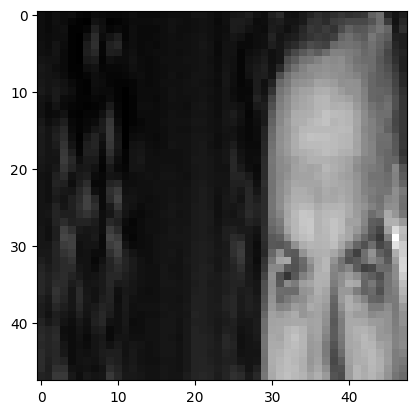


True label:  Surprise


In [ ]:
image, label = test_dataset[1]
model.float()
visualize_prediction(image, model)
print('\nTrue label: ', classes[int(label)])

In [ ]:
def test_model(model, testloader):
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

    accuracy = 100 * correct / total
    print('Accuracy of the network: %.2f %%' % accuracy)

    return true_labels, predicted_labels


In [ ]:
# Print accuracy on test data
model.double()
true_labels, predicted_labels = test_model(model, test_loader)

Accuracy of the network: 32.77 %


---

# BONUS TASK

### How can you improve the performance of your model given that the number of datapoints is fixed?

##### Hint: A very simple fix (discussed in Lab 2) is to use a pretrained CNN model. The pretrained model could be trained on any dataset (eg Imagenet) and the first few layers of the same can be directly used for this task.

### You are encouraged to try out different pretrained models like ResNet/VGG/AlexNet and see how the performance improves. Do all the models result in similar accuracy?

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify the model's architecture for CIFAR-10 classification
num_classes = 10
model.fc = nn.Linear(512, num_classes)

# Move the model to the device (CPU or GPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation on the test set
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Accuracy: {test_accuracy:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/3]: Train Loss: 0.9446, Train Accuracy: 68.45%, Test Accuracy: 74.55%
Epoch [2/3]: Train Loss: 0.6510, Train Accuracy: 78.19%, Test Accuracy: 76.08%
Epoch [3/3]: Train Loss: 0.5154, Train Accuracy: 82.68%, Test Accuracy: 80.10%


it takes lot of execution time to train all the models so i just provided the code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim      # by nagababu fmml20220374
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the model names and corresponding model classes
model_names = ['resnet18', 'vgg16', 'alexnet']
models_dict = {
    'resnet18': models.resnet18,
    'vgg16': models.vgg16,
    'alexnet': models.alexnet
}

# Iterate over the models
for model_name in model_names:
    # Load pre-trained model
    model = models_dict[model_name](pretrained=True)

    # Modify the model for CIFAR-10 classification (change output layer)
    num_classes = 10
    if 'resnet' in model_name:
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif 'vgg' in model_name:
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif 'alexnet' in model_name:
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    # Move model to the device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 1

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        # Evaluation on the test set
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total

        print(f"Model: {model_name}, Epoch [{epoch+1}/{num_epochs}]: "
              f"Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
